# This project compares classification performance of Machine Learning Models on Audio MNIST Dataset. It is divided into four parts.


#### Part I contains import of necessary tools, data loading and preparation, data splitting, data augmentation and feature extraction and scaling.

#### Part II is for building model, training and performance evaluation of three neural network models - Artificial Neural Network(ANN), Convolutional Neural Network (CNN) and Recurrent Neural Network(RNN-LSTM).

#### Part III is for three classical ML models - Logistic Regression (L1/L2), Decision Trees and Random Forest. 

#### Part IV is for two unsupervisory learning models: k-Means and Gaussian Mixture Model.


## Imports

In [25]:
# 1. Imports

import os
import re
import numpy as np
from glob import glob
from collections import Counter
from sklearn.model_selection import train_test_split
import librosa
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import LSTM, SimpleRNN
from tensorflow.keras.utils import to_categorical
%matplotlib inline
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import time
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA






## Data Loading

In [26]:
# Path to dataset on Ubuntu server

data_dir = "/home/akb/MNIST_Audio_Data" 


In [27]:
# Collect all .wav files

all_files = glob(os.path.join(data_dir, "*", "*.wav"))

file_paths, digits, speakers = [], [], []

# Regex pattern: filenames like 3_12_1.wav → digit=3, speaker=12
pattern = re.compile(r"(\d+)_(\d+)_\d+\.wav$")


In [28]:
# Parse filenames
for fpath in all_files:
    fname = os.path.basename(fpath)
    match = pattern.match(fname)
    if match:
        digit, speaker = match.groups()
        file_paths.append(fpath)
        digits.append(int(digit))
        speakers.append(speaker)

# Convert to numpy arrays
file_paths = np.array(file_paths)
digits     = np.array(digits)
speakers   = np.array(speakers)


In [29]:
# Summary 

print("Data loading complete")
print("Total audio files:", len(file_paths))
print("Unique digits:", np.unique(digits))
print("Unique speakers:", len(np.unique(speakers)))
print("\nSamples per digit:")
print(dict(Counter(digits)))

Data loading complete
Total audio files: 30000
Unique digits: [0 1 2 3 4 5 6 7 8 9]
Unique speakers: 60

Samples per digit:
{np.int64(3): 3000, np.int64(5): 3000, np.int64(8): 3000, np.int64(4): 3000, np.int64(7): 3000, np.int64(9): 3000, np.int64(6): 3000, np.int64(0): 3000, np.int64(1): 3000, np.int64(2): 3000}


In [30]:
# 6. Sample Check

if len(file_paths) > 0:
    print("\nExample file:", file_paths[0])
    print("Digit:", digits[0], "| Speaker:", speakers[0])
else:
    print("⚠️ No .wav files found in:", data_dir)


Example file: /home/akb/MNIST_Audio_Data/20/3_20_23.wav
Digit: 3 | Speaker: 20


## Data Splitting - Speakerwise Train/Test Split

In [22]:
# 7. Speaker-wise Train/Test Split

# Get unique speakers
unique_speakers = np.unique(speakers)

# Split speakers into train/test groups
train_speakers, test_speakers = train_test_split(
    unique_speakers,
    test_size=0.1,       # 10% speakers in test
    random_state=42
)

# Create boolean masks
train_mask = np.isin(speakers, train_speakers)
test_mask  = np.isin(speakers, test_speakers)

# Apply masks
X_train, X_test = file_paths[train_mask], file_paths[test_mask]
y_train, y_test = digits[train_mask], digits[test_mask]

print(f"Unique speakers total: {len(unique_speakers)}")
print(f"Speakers in train: {len(train_speakers)}, test: {len(test_speakers)}")
print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")


Unique speakers total: 60
Speakers in train: 54, test: 6
Train samples: 27000, Test samples: 3000


## Data Augmentation

In [31]:
# Add noise, time shift, pitch shift and speed change to make the model more robust


def add_noise(y, noise_factor=0.005):
    return y + noise_factor * np.random.randn(len(y))

def time_shift(y, shift_max=0.1):
    shift = int(len(y) * np.random.uniform(-shift_max, shift_max))
    return np.roll(y, shift)

def pitch_shift(y, sr, n_steps=2):
    steps = float(np.random.uniform(-n_steps, n_steps))
    try: return librosa.effects.pitch_shift(y.astype(np.float32), sr, n_steps=steps)
    except: return y

def speed_change(y, speed_range=0.1):
    rate = float(np.random.uniform(1 - speed_range, 1 + speed_range))
    try: return librosa.effects.time_stretch(y.astype(np.float32), rate)
    except: return y

## Feature Extraction and Scaling

In [32]:
# 9. Return a uniform feature array for all audio files, regardless of their length.

def extract_features(file_list, n_mfcc=40, max_len=100, augment=False):
    features = []
    for f in file_list:
        y, sr = librosa.load(f, sr=None) # load audio
        # Apply augmentation
        if augment:
            choice = np.random.choice(["none", "noise", "shift", "pitch", "speed"])
            if choice == "noise":
                y = add_noise(y)
            elif choice == "shift":
                y = time_shift(y)
            elif choice == "pitch":
                y = pitch_shift(y, sr)
            elif choice == "speed":
                y = speed_change(y)
                
        # Extract MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Pad/truncate to fixed length
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        features.append(mfcc)
    return np.array(features)

# Extract MFCC features
X_train_feat = extract_features(X_train, augment=True)
X_test_feat  = extract_features(X_test, augment=True)

# Flatten for scaler
n_train, n_mfcc, max_len = X_train_feat.shape
X_train_flat = X_train_feat.reshape(n_train, -1)
X_test_flat  = X_test_feat.reshape(len(X_test_feat), -1)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

# Reshape for ANN/CNN/RNN
X_train_ann = X_train_scaled  # Already 2D
X_test_ann  = X_test_scaled

X_train_cnn = X_train_scaled.reshape(n_train, n_mfcc, max_len, 1)
X_test_cnn  = X_test_scaled.reshape(len(X_test_feat), n_mfcc, max_len, 1)

X_train_rnn = X_train_scaled.reshape(n_train, n_mfcc, max_len).transpose(0, 2, 1)
X_test_rnn  = X_test_scaled.reshape(len(X_test_feat), n_mfcc, max_len).transpose(0, 2, 1)

# Labels
from tensorflow.keras.utils import to_categorical
num_classes = len(np.unique(digits))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("Shapes:")
print("ANN:", X_train_ann.shape)
print("CNN:", X_train_cnn.shape)
print("RNN:", X_train_rnn.shape)


Shapes:
ANN: (27000, 4000)
CNN: (27000, 40, 100, 1)
RNN: (27000, 100, 40)


# Part II Neural Networks

## ANN Model

In [13]:
def build_ann(input_dim, num_classes):
    model_ann = Sequential([
        Input(shape=(input_dim,)),               
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_ann

ann = build_ann(X_train_ann.shape[1], num_classes)
ann.summary()

I0000 00:00:1756148605.378635   55632 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6131 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,024,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,058,442 (4.04 MB)

 Trainable params: 1,058,442 (4.04 MB)

 Non-trainable params: 0 (0.00 B)

## CNN Model

In [14]:
def build_cnn(input_shape, num_classes):
    model_cnn = Sequential([
        Input(shape=input_shape),                
        Conv2D(32, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_cnn
cnn = build_cnn(X_train_cnn.shape[1:], num_classes)
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 98, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 23, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 11776)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,507,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,527,562 (5.83 MB)

 Trainable params: 1,527,562 (5.83 MB)

 Non-trainable params: 0 (0.00 B)

## RNN Model

In [15]:
def build_rnn(input_shape, num_classes):
    model_rnn = Sequential([
        Input(shape=input_shape),               
        LSTM(128, return_sequences=False),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model_rnn
rnn = build_rnn(X_train_rnn.shape[1:], num_classes)
rnn.summary()
    

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,330 (407.54 KB)

 Trainable params: 104,330 (407.54 KB)

 Non-trainable params: 0 (0.00 B)

## Define a Timing Call back

In [16]:
class TimingCallback(Callback):
    def on_train_begin(self, logs=None):
        self.times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_start)

## Train ANN Model

In [17]:
# Train ANN
time_ann = TimingCallback()
history_ann = ann.fit(
    X_train_ann, y_train_cat,
    validation_data=(X_test_ann, y_test_cat),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[time_ann]
)


2025-08-25 12:03:48.135762: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 432000000 exceeds 10% of free system memory.
2025-08-25 12:03:48.468410: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 432000000 exceeds 10% of free system memory.


Epoch 1/50


2025-08-25 12:03:49.085694: I external/local_xla/xla/service/service.cc:163] XLA service 0x7df204004c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-25 12:03:49.085708: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-08-25 12:03:49.107661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-25 12:03:49.211194: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-08-25 12:03:49.285211: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-25 12:03:49.285243: 

101/844 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5412 - loss: 1.5966

I0000 00:00:1756148632.675388   56560 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


814/844 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7787 - loss: 0.7740

2025-08-25 12:03:54.127577: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-25 12:03:54.127608: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-25 12:03:54.819816: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_814', 16 bytes spill stores, 16 bytes spill loads



844/844 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7817 - loss: 0.7638

2025-08-25 12:03:56.732337: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-25 12:03:56.944444: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_73', 8 bytes spill stores, 8 bytes spill loads

2025-08-25 12:03:57.134958: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_80', 20 bytes spill stores, 20 bytes spill loads

2025-08-25 12:03:57.979891: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does

844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8617 - loss: 0.4835 - val_accuracy: 0.9467 - val_loss: 0.1770
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9307 - loss: 0.2171 - val_accuracy: 0.9353 - val_loss: 0.2217
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9492 - loss: 0.1685 - val_accuracy: 0.9457 - val_loss: 0.2072
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9562 - loss: 0.1435 - val_accuracy: 0.9353 - val_loss: 0.2732
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9624 - loss: 0.1295 - val_accuracy: 0.9363 - val_loss: 0.2734
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9624 - loss: 0.1334 - val_accuracy: 0.9530 - val_loss: 0.2220
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9700 - loss: 0.1176 - val_accuracy: 0.9410 - val_loss: 0.2399
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9706 - loss: 0.1097 - val_accuracy: 0.9513 - val

# Train CNN model

In [18]:
# CNN
time_cnn = TimingCallback()
history_cnn = cnn.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[time_cnn]
)

Epoch 1/50


2025-08-25 12:05:00.526488: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 432000000 exceeds 10% of free system memory.
2025-08-25 12:05:00.865513: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 432000000 exceeds 10% of free system memory.
2025-08-25 12:05:01.754077: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-08-25 12:05:02.503152: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_893', 520 bytes spill stores, 520 bytes spill loads



844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8771 - loss: 0.3736 - val_accuracy: 0.9567 - val_loss: 0.1286
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9592 - loss: 0.1218 - val_accuracy: 0.9537 - val_loss: 0.1309
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9726 - loss: 0.0821 - val_accuracy: 0.9667 - val_loss: 0.0961
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9802 - loss: 0.0627 - val_accuracy: 0.9653 - val_loss: 0.1150
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9850 - loss: 0.0448 - val_accuracy: 0.9667 - val_loss: 0.1124
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9863 - loss: 0.0405 - val_accuracy: 0.9683 - val_loss: 0.1162
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9895 - loss: 0.0328 - val_accuracy: 0.9590 - val_loss: 0.1426
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9899 - loss: 0.0319 - val_accuracy: 0.9660 - val_

## Train RNN Model

In [19]:
# RNN
time_rnn = TimingCallback()
history_rnn = rnn.fit(
    X_train_rnn, y_train_cat,
    validation_data=(X_test_rnn, y_test_cat),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[time_rnn]
)

Epoch 1/50


2025-08-25 12:07:21.162870: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 432000000 exceeds 10% of free system memory.


844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.4428 - loss: 1.4740 - val_accuracy: 0.7087 - val_loss: 0.9282
Epoch 2/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7657 - loss: 0.7831 - val_accuracy: 0.8343 - val_loss: 0.5687
Epoch 3/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8545 - loss: 0.4757 - val_accuracy: 0.8070 - val_loss: 0.5756
Epoch 4/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8899 - loss: 0.3404 - val_accuracy: 0.9177 - val_loss: 0.2655
Epoch 5/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9321 - loss: 0.2236 - val_accuracy: 0.9300 - val_loss: 0.2429
Epoch 6/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9491 - loss: 0.1630 - val_accuracy: 0.9403 - val_loss: 0.2025
Epoch 7/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9524 - loss: 0.1573 - val_accuracy: 0.9283 - val_loss: 0.3208
Epoch 8/50
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9587 - loss: 0.1344 - val_accuracy: 0.9390 - val_

# Training Time per epoch plot

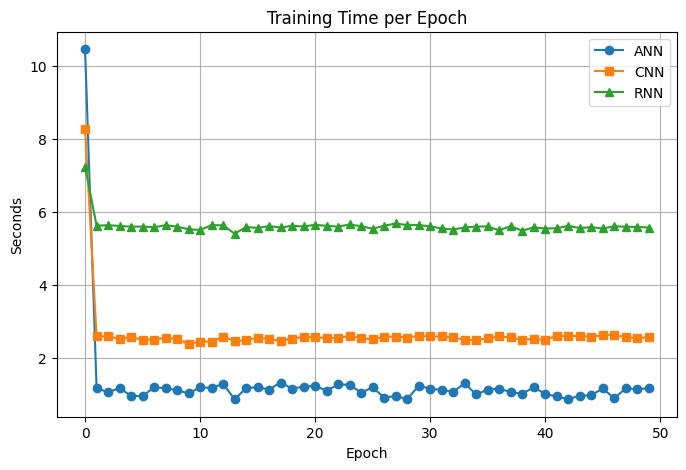

In [22]:
plt.figure(figsize=(8,5))
plt.plot(time_ann.times, label='ANN', marker='o')
plt.plot(time_cnn.times, label='CNN', marker='s')
plt.plot(time_rnn.times, label='RNN', marker='^')

plt.title("Training Time per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Seconds")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation on Test Data

In [23]:
# ANN:
test_loss_ann, test_acc_ann = ann.evaluate(X_test_ann, y_test_cat, verbose=0)
print(f"ANN Test Accuracy: {test_acc_ann:.4f} , ANN Test Loss: {test_loss_ann:.4f}")

ANN Test Accuracy: 0.9493 , ANN Test Loss: 0.8297


In [24]:
# CNN:
test_loss_cnn, test_acc_cnn = cnn.evaluate(X_test_cnn, y_test_cat, verbose=0)
print(f"CNN Test Accuracy: {test_acc_cnn:.4f} , CNN Test Loss: {test_loss_cnn:.4f}")

CNN Test Accuracy: 0.9647 , CNN Test Loss: 0.3089


In [25]:
# RNN:
test_loss_rnn, test_acc_rnn = rnn.evaluate(X_test_rnn, y_test_cat, verbose=0)
print(f"RNN Test Accuracy: {test_acc_rnn:.4f} , RNN Test Loss: {test_loss_rnn:.4f}")

RNN Test Accuracy: 0.9583 , RNN Test Loss: 0.2704


## Plot Training and Validation Accuracy

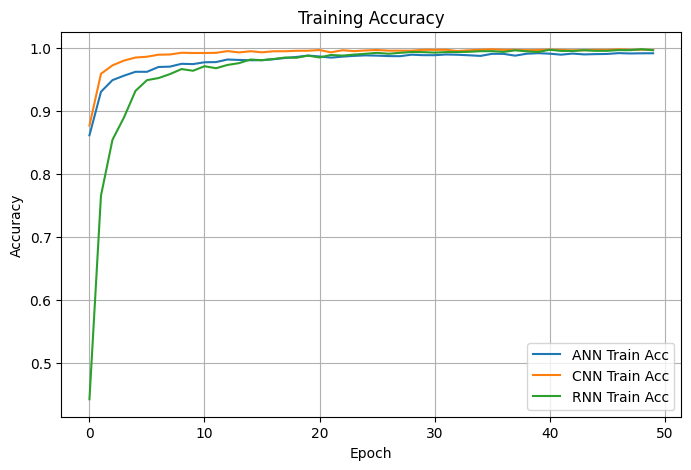

In [26]:
# Training Accuracy Plot

plt.figure(figsize=(8,5))
plt.plot(history_ann.history['accuracy'], label='ANN Train Acc')
plt.plot(history_cnn.history['accuracy'], label='CNN Train Acc')
plt.plot(history_rnn.history['accuracy'], label='RNN Train Acc')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('training_accuracy.png')   # Saves the plot
plt.show()



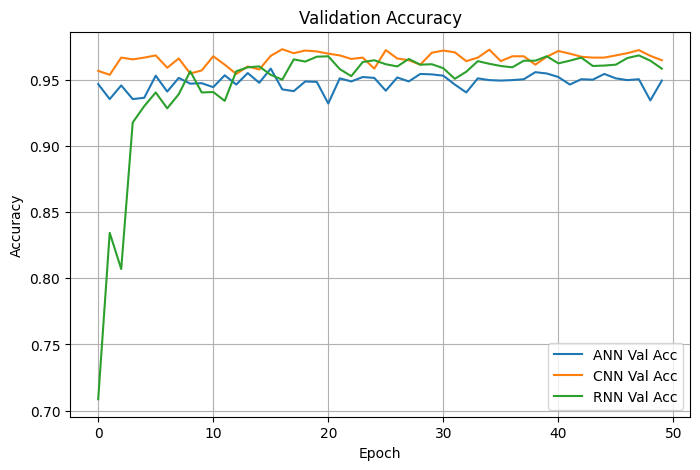

In [27]:
# Validation Accuracy Plot

plt.figure(figsize=(8,5))
plt.plot(history_ann.history['val_accuracy'], label='ANN Val Acc')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val Acc')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val Acc')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('validation_accuracy.png')   # Saves the plot
plt.show()



## Plot Test Loss 

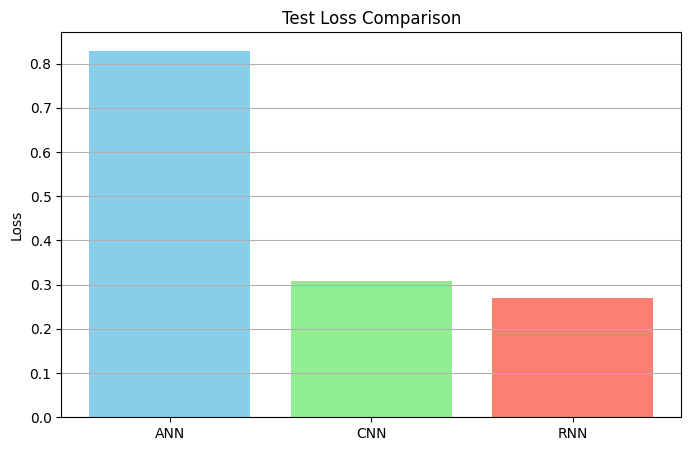

In [28]:
# Plot Test Loss

plt.figure(figsize=(8,5))
plt.bar(['ANN', 'CNN', 'RNN'], [test_loss_ann, test_loss_cnn, test_loss_rnn], color=['skyblue','lightgreen','salmon'])
plt.title('Test Loss Comparison')
plt.ylabel('Loss')
plt.grid(axis='y')
plt.savefig('training_loss.png')   # Saves the plot
plt.show()


# Part III  Classic ML Models

In [51]:
# Prepare x_train and y-train for classic ML
X_train_feat_ml = X_train_ann
X_test_feat_ml = X_test_ann


## Logistic Regression Model (L2 - Ridge)

In [60]:
# L2 Regularization (Ridge)

logreg_l2 = LogisticRegression(
    penalty='l2',       # L2 regularization
    solver='lbfgs',     # iterative solver
    tol=1e-3,           # stop if changes < 0.001
    max_iter=500,        # stop if iterations exceed 500
    verbose=1
)
start_time_l2 = time.time()
logreg_l2.fit(X_train_feat_ml, y_train)
end_time_l2 = time.time()

time_l2 = end_time_l2 - start_time_l2
y_pred_l2 = logreg_l2.predict(X_test_feat_ml)
acc_l2 = accuracy_score(y_test, y_pred_l2)

print(f"L2 Logistic Regression  training time: {time_l2:.2f} seconds")
print(f"L2 Accuracy: {acc_l2:.4f}")
# Print number of iterations actually used
print("Iterations used:", logreg_l2.n_iter_)

test_mse ={}

l2mse = mean_squared_error(y_test, y_pred_l2)
test_mse['L2 Ridge'] = l2mse
print(f"(L2 Ridge Test MSE: {l2mse:.4f}")


L2 Logistic Regression  training time: 8.07 seconds
L2 Accuracy: 0.9200
Iterations used: [29]
(L2 Ridge Test MSE: 1.1797


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.0s finished


## Decision Tree Classifier

In [53]:
# Decision Tree  

# Convert one-hot labels, back to integer

y_train_dt = np.argmax(y_train_cat, axis=1)  # shape (n_samples,)
y_test_dt  = np.argmax(y_test_cat, axis=1)

X_train_dt = X_train_ann
X_test_dt  = X_test_ann

# Initialize Decision Tree
dt_model = DecisionTreeClassifier(
    criterion='gini',       # 'gini' or 'entropy'
    max_depth=None,         # None = expand until all leaves are pure
    random_state=42
)

# Train the model
dt_model.fit(X_train_dt, y_train_dt)

# Make predictions
y_pred = dt_model.predict(X_test_dt)

# Evaluate
acc_dt = accuracy_score(y_test_dt, y_pred)
print("Decision Tree Test Accuracy:", acc)

# Detailed evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test_dt, y_pred))
print("Classification Report:\n", classification_report(y_test_dt, y_pred))

dtmse = mean_squared_error(y_test, y_pred)
test_mse['Decision Tree'] = dtmse
print(f"Decision Tree Test MSE: {dtmse:.4f}")


Decision Tree Test Accuracy: 0.7856666666666666
Confusion Matrix:
 [[218   5  29  11   6   1   2  26   0   2]
 [  3 229   5   3   9  17   0   6   3  25]
 [ 12   4 213  19   3  12  12  18   5   2]
 [  6   4  17 242   4   3   6   2   6  10]
 [ 11   2  16   5 221  21   5   8   3   8]
 [  3  12   2   4  11 243   9   9   0   7]
 [  8   0   4  10   1   3 262   7   4   1]
 [  8   4  18  22   5  12   3 222   0   6]
 [  0   0   8   8   1   0   1   0 280   2]
 [  7  14   2  13   2  20   2   6   7 227]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76       300
           1       0.84      0.76      0.80       300
           2       0.68      0.71      0.69       300
           3       0.72      0.81      0.76       300
           4       0.84      0.74      0.79       300
           5       0.73      0.81      0.77       300
           6       0.87      0.87      0.87       300
           7       0.73      0.74      0.74  

## Random Forest Classifier

In [33]:
# Random Forest 
 
y_train_rf = y_train_dt
y_test_rf  = y_test_dt

X_train_rf = X_train_dt
X_test_rf  = X_test_dt

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,     # Number of trees in the forest
    criterion="gini",     # 'gini' or 'entropy'
    max_depth=None,       # Let trees expand fully (can tune this)
    random_state=42,
    n_jobs=-1             # Use all CPU cores for speed
)

# Train the model
rf_model.fit(X_train_rf, y_train_rf)

# Make predictions
y_pred_rf = rf_model.predict(X_test_rf)

# Evaluate
acc_rf = accuracy_score(y_test_rf, y_pred_rf)
print("Random Forest Test Accuracy:", acc_rf)

# Detailed metrics
print("\nConfusion Matrix:\n", confusion_matrix(y_test_rf, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test_rf, y_pred_rf))

rfmse = mean_squared_error(y_test, y_pred_rf)
test_mse['Random Forest'] = rfmse
print(f"Random Forest Test MSE: {rfmse:.4f}")




Random Forest Test Accuracy: 0.951

Confusion Matrix:
 [[275   0  13   5   0   1   0   6   0   0]
 [  0 289   1   1   2   5   0   0   0   2]
 [ 15   0 276   6   0   0   1   2   0   0]
 [  1   2   8 284   0   2   0   2   1   0]
 [  0   4   1   0 281  10   0   2   1   1]
 [  0   0   0   0   0 297   0   3   0   0]
 [  0   0   1   3   0   0 295   0   1   0]
 [  0   0   6  10   0   1   1 282   0   0]
 [  0   0   1   6   0   0   1   1 291   0]
 [  0   6   1   2   0   0   0   2   6 283]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.93       300
           1       0.96      0.96      0.96       300
           2       0.90      0.92      0.91       300
           3       0.90      0.95      0.92       300
           4       0.99      0.94      0.96       300
           5       0.94      0.99      0.96       300
           6       0.99      0.98      0.99       300
           7       0.94      0.94      0.94       300
  

## Plot MSE of Three Classic Machine Language Models

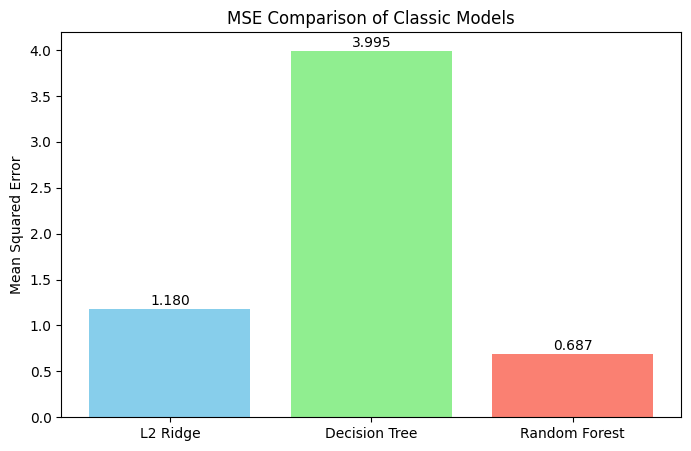

In [49]:
models = list(test_mse.keys())
mse_scores = list(test_mse.values())

plt.figure(figsize=(8,5))
bars = plt.bar(models, mse_scores, color=["skyblue", "lightgreen", "salmon"])
plt.ylabel("Mean Squared Error")
plt.title("MSE Comparison of Classic Models")

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", 
             ha="center", va="bottom")

plt.show()


## Plot Accuracy of Three Classic ML Models

['L2 Ridge', 'Decision Tree', 'Random Forest']


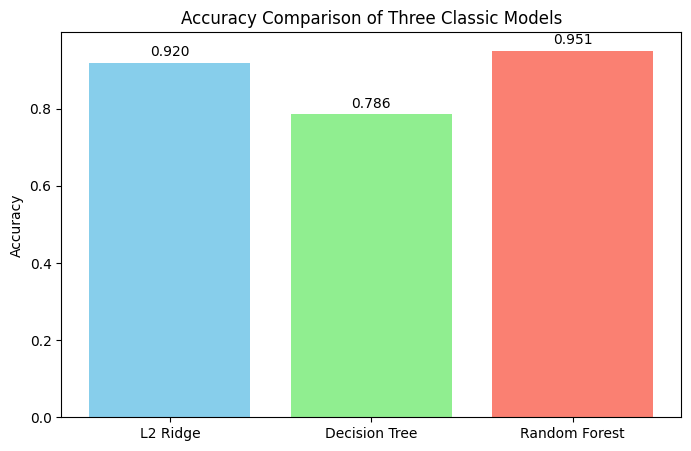

In [59]:
# Accuracy Plot

models = ['L2 Ridge', 'Decision Tree', 'Random Forest']
acc_scores = [acc_l2, acc_dt, acc_rf]
print(models)

plt.figure(figsize=(8,5))
bars = plt.bar(models, acc_scores, color=["skyblue", "lightgreen", "salmon"])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of Three Classic Models")

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.3f}", 
             ha="center", va="bottom")

plt.show()


# Part IV     Unsupervised Learning

## Apply PCA to data


In [34]:
# PCA 

X_scaled = np.concatenate([X_train_scaled, X_test_scaled], axis=0)


# Convert to float64 (important for numerical stability in GMM/PCA)
X_scaled = X_scaled.astype("float64")

# 3. Apply PCA
pca = PCA(n_components=1000, random_state=42)   # keep top 1000 dimensions
X_pca = pca.fit_transform(X_scaled)

print("Original shape:", X_scaled.shape)
print("Reduced shape:", X_pca.shape)

# 4. Explained variance ratio
print("Variance explained by first 1000 components:", np.sum(pca.explained_variance_ratio_))


Original shape: (30000, 4000)
Reduced shape: (30000, 1000)
Variance explained by first 1000 components: 0.9210018190042712


## K-Means Clustering

In [36]:
#  K-Means Clustering

y = digits   # should have shape (30000,)

n_clusters = 10   # because AudioMNIST has 10 digits (0–9)
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

clusters = kmeans.fit_predict(X_pca)

# Evaluation

sil_score_kmeans = silhouette_score(X_pca, clusters)
print("Silhouette Score:", sil_score_kmeans)

# compare clustering vs actual
ari_score_kmeans = adjusted_rand_score(y, clusters)

print("Adjusted Rand Index:", ari_score_kmeans)

# Quick peek at assignments
print("\nFirst 20 true labels:   ", y[:20])
print("First 20 cluster labels:", clusters[:20])

Silhouette Score: 0.029824919693174457
Adjusted Rand Index: 0.003796003618033335

First 20 true labels:    [3 5 8 4 8 7 9 8 5 4 4 6 0 5 8 1 7 2 1 6]
First 20 cluster labels: [5 7 8 7 6 8 8 4 7 7 8 8 8 8 4 7 1 4 5 8]


## Scatter Plot for K-Means

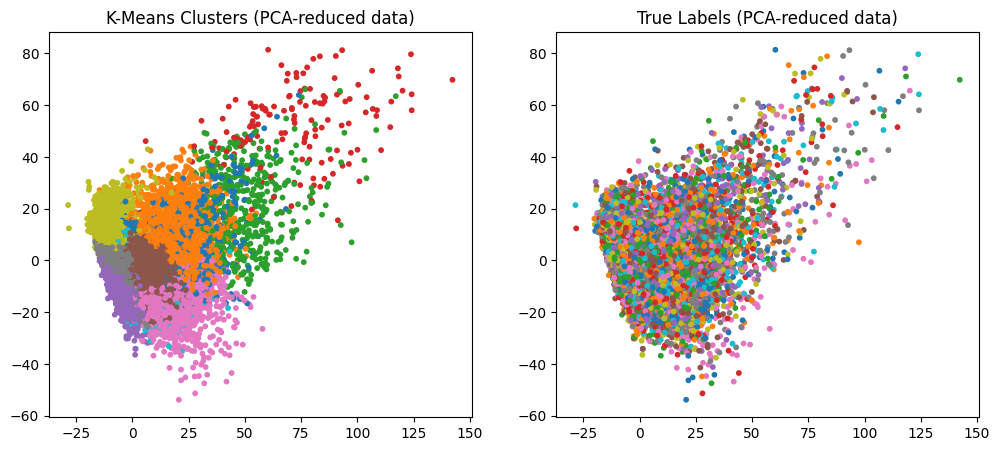

In [38]:
# Scatterplot

plt.figure(figsize=(12, 5))

# Plot clusters found by K-Means
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="tab10", s=10)
plt.title("K-Means Clusters (PCA-reduced data)")

# Plot actual labels for comparison
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab10", s=10)
plt.title("True Labels (PCA-reduced data)")

plt.show()

## Gaussian Mixture Model

In [40]:
# GMM

# Fit Gaussian Mixture Model

n_clusters = 10 # for digits 0-9
gmm = GaussianMixture(
    n_components=10, 
    covariance_type='diag',   # 'full', 'tied', 'diag', 'spherical'
    reg_covar=1e-2,
    max_iter=500,
    random_state=42
)
gmm.fit(X_pca)

# Predict cluster labels

cluster_labels = gmm.predict(X_pca)

#  Evaluate clustering

sil_score_gmm = silhouette_score(X_pca, cluster_labels)
ari_score_gmm = adjusted_rand_score(y, cluster_labels)

print("Silhouette Score:", sil_score_gmm)
print("Adjusted Rand Index:", ari_score_gmm)

# Optional: print first 20 labels
print("\nFirst 20 true labels:   ", y[:20])
print("First 20 cluster labels:", cluster_labels[:20])


Silhouette Score: -0.06737915415211779
Adjusted Rand Index: 0.0012861719282576207

First 20 true labels:    [3 5 8 4 8 7 9 8 5 4 4 6 0 5 8 1 7 2 1 6]
First 20 cluster labels: [6 6 9 2 7 1 9 6 6 2 9 1 0 9 8 2 7 2 8 1]


## Scatterplot for GMM

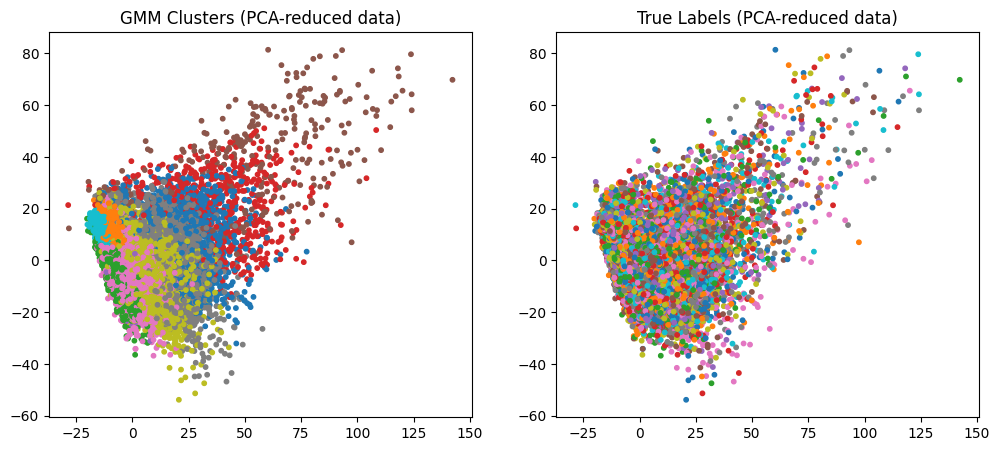

In [41]:
# Scatterplot

plt.figure(figsize=(12, 5))

# Plot clusters found by GMM
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap="tab10", s=10)
plt.title("GMM Clusters (PCA-reduced data)")

# Plot actual labels for comparison
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="tab10", s=10)
plt.title("True Labels (PCA-reduced data)")

plt.show()

## Plot Comparison of Silhoette Score and Adjusted Rand Index of K-Means and GMM

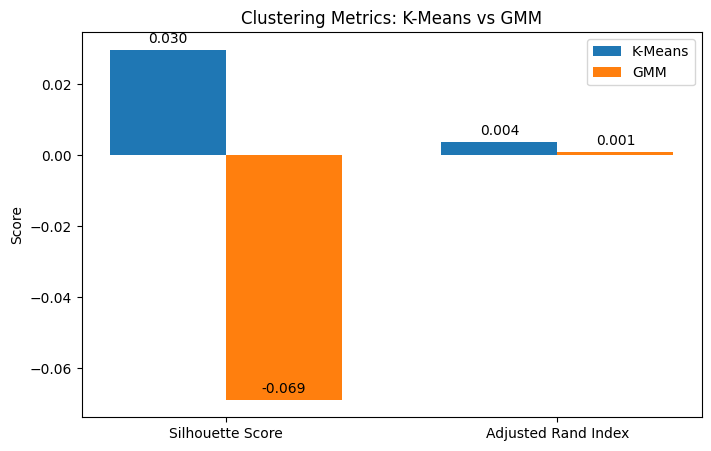

In [42]:
# Put values in a dictionary for easy plotting
scores = {
    "K-Means": [sil_score_kmeans, ari_score_kmeans],
    "GMM": [sil_score_gmm, ari_score_gmm]
}

metrics = ["Silhouette Score", "Adjusted Rand Index"]

# Plot
x = np.arange(len(metrics))  # [0, 1]
width = 0.35  

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, scores["K-Means"], width, label="K-Means")
rects2 = ax.bar(x + width/2, scores["GMM"], width, label="GMM")

# Labels
ax.set_ylabel("Score")
ax.set_title("Clustering Metrics: K-Means vs GMM")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Show values on bars
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f"{height:.3f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')

plt.show()


## End of Program
